#Imports

In [1]:
!pip install transformers
!pip install evaluate
!pip install rouge


import torch
import json
from tqdm import tqdm
import torch.nn as nn
from torch.optim import Adam
import nltk
import spacy
import string
import evaluate  # Bleu
from torch.utils.data import Dataset, DataLoader, RandomSampler
import pandas as pd
import numpy as np
import transformers
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from transformers import T5Tokenizer, T5Model, T5ForConditionalGeneration, T5TokenizerFast

from transformers import RealmConfig, RealmEmbedder, AutoTokenizer, RealmKnowledgeAugEncoder, RealmScorer


import warnings
warnings.filterwarnings("ignore")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# REALM

In [3]:
import pandas as pd
df = pd.read_csv("data_withNeg1k-5Cols.csv")
df = df.dropna()

In [4]:
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
from tqdm import tqdm

candidates_texts = []
input_texts = []

for index, row in df.iterrows():
    sentences = []
    input_texts.append(row['question'])
    sentences.append(row['context'])
    sentences.append(row['neg_context0'])
    sentences.append(row['neg_context1'])
    sentences.append(row['neg_context2'])
    sentences.append(row['neg_context3'])
    sentences.append(row['neg_context4'])
    candidates_texts.append(sentences)

print(len(input_texts))
print(len(candidates_texts[0]))

3394
6


In [ ]:
import torch
from transformers import AutoTokenizer, RealmScorer

tokenizer = AutoTokenizer.from_pretrained("google/realm-cc-news-pretrained-scorer")
model = RealmScorer.from_pretrained("google/realm-cc-news-pretrained-scorer", num_candidates=6)

relevance_scores = []

for idx in range(len(input_texts)):
  input_trunc = ' '.join(input_texts[idx].split()[:512])
  candidates_trunc = [' '.join(cand.split()[:512]) for cand in candidates_texts[idx][:]]
  inputs = tokenizer(input_trunc, max_length=512, padding="max_length", truncation=True, pad_to_max_length=True, return_tensors="pt")
  candidates_inputs = tokenizer.batch_encode_candidates(candidates_trunc, max_length=512, padding="max_length", truncation=True, pad_to_max_length=True, return_tensors="pt")

  outputs = model(
      **inputs,
      candidate_input_ids=candidates_inputs.input_ids,
      candidate_attention_mask=candidates_inputs.attention_mask,
      candidate_token_type_ids=candidates_inputs.token_type_ids,
  )
  relevance_scores.append(outputs.relevance_score)

# Loss Analysis

In [10]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("data_withNeg2k_realm.csv")
df = df.dropna()

In [11]:
df.loc[0]

question               Is SLC4A1-associated distal renal tubular acid...
answer                 SLC4A1 associated distal renal tubular acidosi...
context                of the condition, gene mutations affect only o...
span_start                                                          6586
span_end                                                            7487
token_length_answer                                                  210
n_tokens                                                            1480
neg_context0           autosomal dominant and autosomal recessive for...
neg_context1           ENCYCLOPEDIA Distal renal tubular acidosis Gen...
neg_context2           adults. This bone disorder is characterized by...
neg_context3           acidosis later in life. Some people with SLC4A...
neg_context4           with the features described above have complet...
relevantContext                                                        0
Name: 0, dtype: object

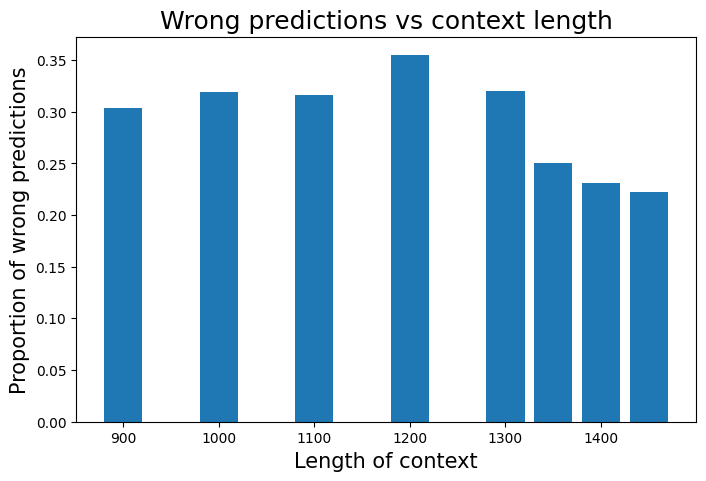

In [17]:
wrong_preds = df[(df['relevantContext'] > 0)]
len(wrong_preds)


lengths = [900, 1000, 1100, 1000, 1200, 1300, 1350, 1400, 1450]
wrongs = [len(wrong_preds[wrong_preds['n_tokens'] > l])/len(df[df['n_tokens'] > l]) for l in lengths]

# sns.histplot(y=wrongs, x=lengths)
# plt.title('Wrong predictions vs context length')

fig = plt.subplots(figsize = (8, 5))

# creating the bar plot
plt.bar(lengths, wrongs, width=40)

plt.xlabel("Length of context", fontsize=15)
plt.ylabel("Proportion of wrong predictions", fontsize=15)
plt.title("Wrong predictions vs context length", fontsize=18)
plt.show()

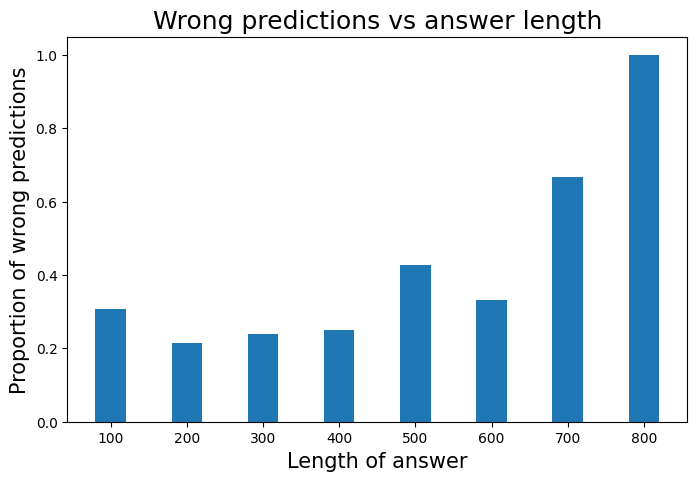

In [18]:
fig = plt.subplots(figsize = (8, 5))

lengths = [100, 200, 300, 400, 500, 600, 700, 800]
wrongs = [len(wrong_preds[wrong_preds['token_length_answer'] > l])/len(df[df['token_length_answer'] > l]) for l in lengths]

plt.title('Wrong predictions vs answer length', fontsize=18)

# sns.histplot(y=wrongs, x=lengths)

# creating the bar plot
plt.bar(lengths, wrongs, width=40)

plt.xlabel("Length of answer", fontsize=15)
plt.ylabel("Proportion of wrong predictions", fontsize=15)
plt.show()